In [1]:
# This code is used to create the Grad-CAM visualisations

In [1]:
# runs with tf 2.x

from vis.utils import utils
from vis.visualization import visualize_activation, get_num_filters, visualize_saliency, overlay, visualize_cam
from vis.input_modifiers import Jitter

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from numpy import expand_dims
import random
import os.path
import time
import PIL
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix

from keras import activations
from keras.models import Sequential, load_model, Model
from keras.optimizers import SGD, Adam
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers

Using TensorFlow backend.


In [7]:
# This block is used to load the data into RAM

# list of dirs containing the data - one for the porosity labeled data and one for the no_porosity_labeled data
dirs = [ '/media/jan/Volume_big/datasets/Square_data_Gridsize_220_100µm_corrected/3layer/generated_ds/mixed/porosity',
         '/media/jan/Volume_big/datasets/Square_data_Gridsize_220_100µm_corrected/3layer/generated_ds/mixed/no_porosity']


length = 4632 # number of samples per category 
random_seed = 22 
image_paths = []
show_time = True  # can be toggled to show the time for loading the data into RAM 

if show_time:
    start_time = time.time()

# creating a list with paths of all files in each folder     
for d in dirs: 
    cur_paths = []
    for path in os.listdir(d):
        full_path = os.path.join(d,path)  # adding the full path as the label is stored in the path
        cur_paths.append(full_path)
    
    # randomly shuffling the created list and cutting it to the desired length
    # added to the code for being able to deal with non pre-balanced data sets - if folders both have same length nothing happens at this point
    random.seed(random_seed) 
    random.shuffle(cur_paths)
    cur_paths = cur_paths[:length] 
    
    image_paths.append(cur_paths) # appending the cut list to a new list containing all the final paths        

image_paths = [val for sublist in image_paths for val in sublist] # getting the seperate image paths out of the list
random.seed(random_seed)
random.shuffle(image_paths) # randomly shuffling the list containing the final paths

labels = []
data = []
# generating the label from the second last part of path for every element in the list and adding it to labels-list
# loading the np array, resizing and storing it to data-list

for path in image_paths:
    label = path.split(os.path.sep)[-2] # here it is 'porosity' or 'no_porosity' 
    # additionally to the pure label the whole path is stored to make a traceback of model_behaviour possible 
    # the number needs to be changed according to the link to output something like '/porosity/ZP...'
    labels.append([label,path[97:]])
    array = np.load(path)
    # img = Image.fromarray(array)   # could be added if resizing operation was necessary
    # img = img.resize((128, 128), PIL.Image.LANCZOS)
    # array_resized = np.array(img)
    data.append(array)
    
# scale the raw pixel intensities to the range [0, 1] and making arrays out of lists for sklearn-functions
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

# splitting data and labels in train, valid and test set in ratio (0.75, 0.125, 0.125)
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.25, random_state=42)
(validX, testX, validY, testY) = train_test_split(testX, testY, test_size=0.5, random_state=42)

# at this point the lables are an array with entries like ['porosity', '/porosity/ZP3_Slice00690_x:1_y:1.npy']
# the following part splits up the array to generate labels and also a list with the full paths 

trainY_list = []
trainY_path = []
testY_list = []
testY_path = []
validY_list = []
validY_path = []

for row in trainY:
    trainY_list.append(row[0])
    trainY_path.append(row[1]) 
trainY = np.array(trainY_list)
trainY_path = np.array(trainY_path)

for row in testY:
    testY_list.append(row[0])
    testY_path.append(row[1]) 
testY = np.array(testY_list)
testY_path = np.array(testY_path)

for row in validY:
    validY_list.append(row[0])
    validY_path.append(row[1]) 
validY = np.array(validY_list)
validY_path = np.array(validY_path)

# the LabelBinarizer module is used to one hot encode the labels 
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)
validY = lb.transform(validY)

# now the Labels are arrays containing either a '0' for 'no_porosity' or a '1' for 'porosity'
if show_time:
    print(time.time()-start_time)
    
# the shapes of the different data sets are printed  
print('shape training dataset: ' + str(trainX.shape))
print('shape validation dataset: ' + str(validX.shape))
print('shape test dataset: ' + str(testX.shape))

181.2345564365387


In [46]:
# according to the keras vis documentation the sigmoid activation function of the last layer of the model needs to changed to a linear activation function to make the kera vis modules work 

# the same model is loaded two times - one version will be changed, the other version won't because one "normal" version of the model is used to make predictions on data later in the code 
model_changed = load_model( '/home/jan/Documents/NN_Training/Jupyter_nbs/Modelle + Code/dataset_with_16_squares_corrected_threshold_100µm/trained_models_for_work/100µm/mixed/3layer_100µm_mixed_2x16_2x32_3x64.h5')
model_original = load_model( '/home/jan/Documents/NN_Training/Jupyter_nbs/Modelle + Code/dataset_with_16_squares_corrected_threshold_100µm/trained_models_for_work/100µm/mixed/3layer_100µm_mixed_2x16_2x32_3x64.h5')

# Swapping sigmoid activation for linear activation according to keras-vis documentation
layer_idx = -1
model_changed.layers[layer_idx].activation = activations.linear
model_changed = utils.apply_modifications(model_changed)

In [151]:
# These lines of code were used to select the examples shown in the thesis 

for i in range(100):
    print(str(i) + ' ' + lb.inverse_transform(model_name.predict(np.expand_dims(testX[i], axis = 0)))[0])

70 porosity
71 no_porosity
72 porosity
73 no_porosity
74 porosity
75 porosity
76 no_porosity
77 no_porosity
78 porosity
79 no_porosity
80 no_porosity
81 no_porosity
82 no_porosity
83 no_porosity
84 no_porosity
85 no_porosity
86 no_porosity
87 no_porosity
88 no_porosity
89 no_porosity
90 no_porosity
91 porosity
92 no_porosity
93 porosity
94 porosity
95 porosity
96 no_porosity
97 porosity
98 porosity
99 no_porosity


/porosity/ZP1_Slice00795_x:1_y:0.npy
pred.label: porosity
true label: porosity


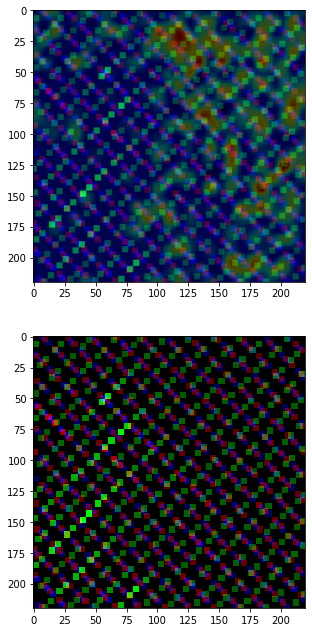

In [56]:
i = 10 # <- number of the desired test image
model_name = model_changed
plt.rcParams['figure.figsize'] = (11, 11)
img = testX[i]
f, ax = plt.subplots(2, 1)

# Here the Saliency map could be shown - not used for work due to limited extractable information
# grads_saliency = visualize_saliency(model_name, layer_idx, filter_indices=None, seed_input=img)

# Grad-CAM
grads_cam = visualize_cam(model_name, layer_idx, filter_indices=0, seed_input=img)   
jet_heatmap = np.uint8(cm.jet(grads_cam)[..., :3] * 255)

# ax[0].imshow(grads_saliency, cmap = 'jet')
ax[0].imshow(jet_heatmap)
ax[0].imshow(img, alpha=0.7, cmap='jet', interpolation='bilinear') # Grad-CAM layed on top of original image
ax[1].imshow(img)

print(testY_path[i])
print('pred.label: ' + lb.inverse_transform(model_original.predict(np.expand_dims(testX[i], axis = 0)))[0])
print('true label: '+ testY_path[i].split('/')[1])